In [1]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from tabulate import tabulate
import warnings
from google.colab import drive

#set the theme for seaborn plots
sns.set_theme(style="darkgrid")

#ignore warnings for cleaner output
warnings.filterwarnings('ignore')

In [2]:
#mount Google Drive
drive.mount('/content/drive')
csv = pd.read_csv("/content/drive/MyDrive/Applied_Data_Science/2018.csv")

#print the table info and its head
csv.set_index('Overall rank', inplace=True)
print(tabulate(csv.head(), headers='keys', tablefmt='grid'), csv.info())

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 156
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country or region             156 non-null    object 
 1   Score                         156 non-null    float64
 2   GDP per capita                156 non-null    float64
 3   Social support                156 non-null    float64
 4   Healthy life expectancy       156 non-null    float64
 5   Freedom to make life choices  156 non-null    float64
 6   Generosity                    156 non-null    float64
 7   Perceptions of corruption     155 non-null    float64
dtypes: float64(7), object(1)
memory usage: 11.0+ KB
+----------------+---------------------+---------+------------------+------------------+---------------------------+--------------------------------+--------------+-----------------------------+
|   Overall rank | Country or region 

In [3]:
#check for missing values and replace spaces in column names with underscores
print(csv.isnull().sum())
csv = csv.dropna()
csv.columns = [col.replace(" ", "_") for col in csv.columns]

Country or region               0
Score                           0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       1
dtype: int64


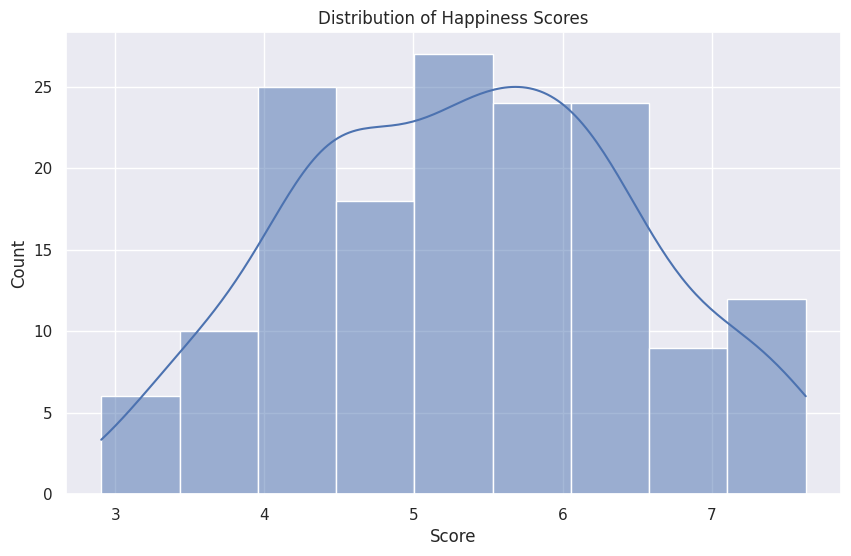

In [4]:
#plot the distribution of happiness scores
plt.figure(figsize=(10, 6))
sns.histplot(csv['Score'], kde=True)
plt.title('Distribution of Happiness Scores')
plt.show()

Categorical columns: Index(['Country_or_region'], dtype='object')


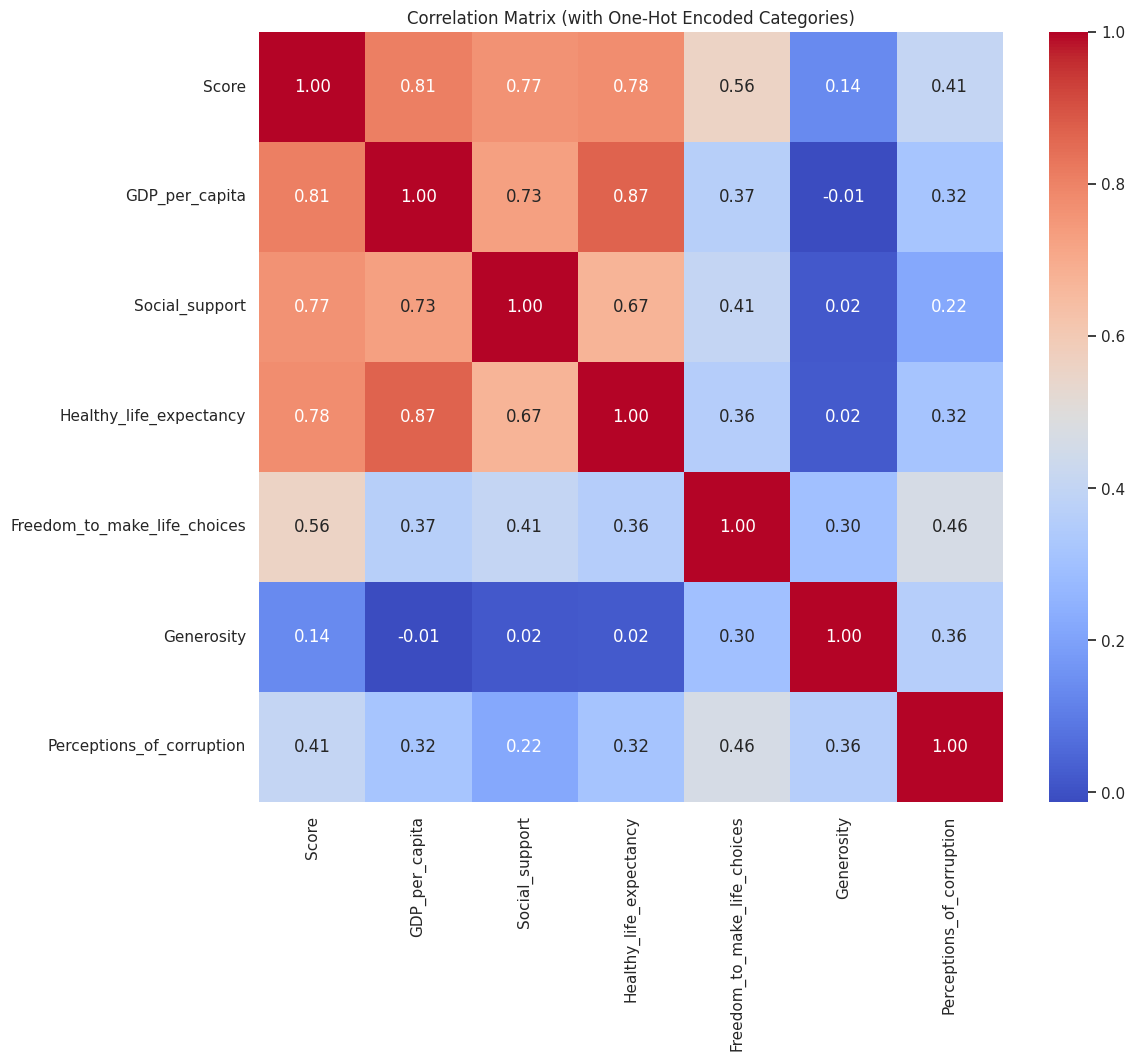

In [5]:
# handling categorical columns
categorical_columns = csv.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)
csv_encoded = pd.get_dummies(csv, columns=categorical_columns, drop_first=True) #one-hot encoding

#compute correlation matrix
numerical_columns = csv_encoded.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_columns.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (with One-Hot Encoded Categories)')
plt.show()

In [7]:
#prepare the dataset for training
X = numerical_columns.drop(['Score'], axis=1, errors='ignore')
y = numerical_columns['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [8]:
#training linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_normalized, y_train)
lr_pred = lr_model.predict(X_test_normalized)

#evaluate linear regression model
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_pred)

#evaluation metrics for linear regrassion model
print('Linear Regression:')
print('Mean Squared Error:', lr_mse)
print('Root Mean Squared Error:', lr_rmse)
print('R-squared:', lr_r2)

Linear Regression:
Mean Squared Error: 0.22188952473486592
Root Mean Squared Error: 0.47105150964078857
R-squared: 0.8189905943894034


In [9]:
#training random forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

#evaluate random forest regressor
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)

#evaluation metrics for random forest regressor
print('Random Forest Regression:')
print('Mean Squared Error:', rf_mse)
print('Root Mean Squared Error:', rf_rmse)
print('R-squared:', rf_r2)

Random Forest Regression:
Mean Squared Error: 0.23393245707741933
Root Mean Squared Error: 0.4836656459553638
R-squared: 0.8091664081068876


In [10]:
#determine the better performing model
if rf_r2 > lr_r2:
    best_model = rf_model
    print('Random Forest model performs better.')
else:
    best_model = lr_model
    print('Linear Regression model performs better')

Linear Regression model performs better


                        feature  coefficient  abs_coefficient
1                Social_support     0.340101         0.340101
0                GDP_per_capita     0.303737         0.303737
3  Freedom_to_make_life_choices     0.274282         0.274282
2       Healthy_life_expectancy     0.238454         0.238454
5     Perceptions_of_corruption     0.058614         0.058614
4                    Generosity     0.037892         0.037892


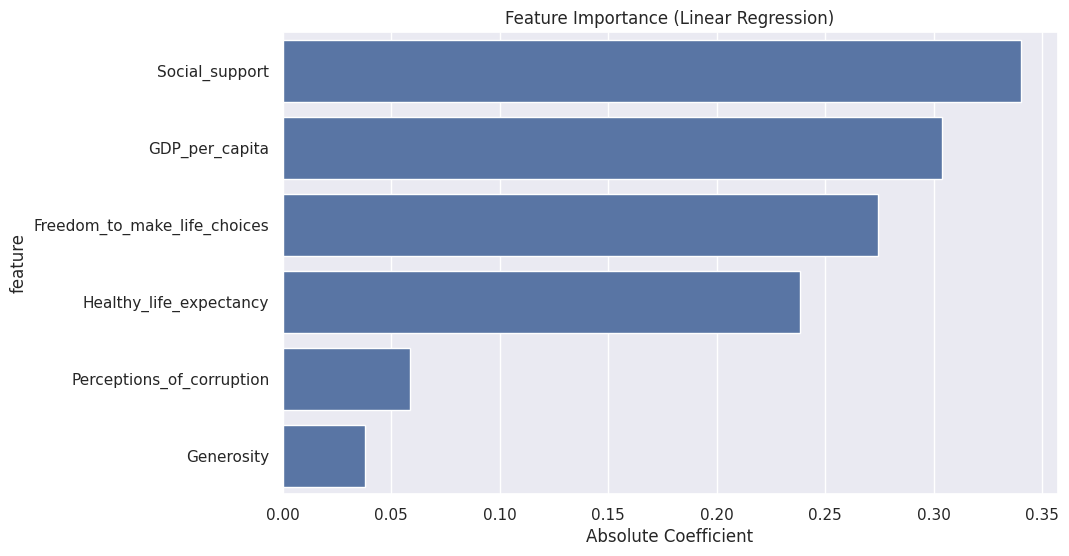

In [11]:
#extract feature importance from lr model
coefficients = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_
})

#sort features by the absolute value of coefficients
coefficients['abs_coefficient'] = coefficients['coefficient'].abs()
coefficients = coefficients.sort_values(by='abs_coefficient', ascending=False)

# Display and plot feature importance
print(coefficients)
plt.figure(figsize=(10, 6))
sns.barplot(x='abs_coefficient', y='feature', data=coefficients.head(10))  # Top 10 features
plt.title('Feature Importance (Linear Regression)')
plt.xlabel('Absolute Coefficient')
plt.show()

In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

#define parameter grid for Ridge
ridge_param_grid = {
    'alpha': [0.1, 1, 10, 100, 1000]  # Regularization strength
}

#initialize Ridge model
ridge_model = Ridge()

#gridSearchCV for Ridge
ridge_search = GridSearchCV(estimator=ridge_model, param_grid=ridge_param_grid, cv=5, scoring='r2')
ridge_search.fit(X_train, y_train)

#print the best parameters and the best score
print("Best Ridge Parameters:", ridge_search.best_params_)
print("Best Ridge R2 Score:", ridge_search.best_score_)

#use the best ridge model
best_ridge_model = ridge_search.best_estimator_

Best Ridge Parameters: {'alpha': 1}
Best Ridge R2 Score: 0.7387721968707581


In [13]:
#predict with the best ridge model
y_pred_ridge = best_ridge_model.predict(X_test)

#evaluate ridge model
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, y_pred_ridge)
print("Ridge Regression MSE:", ridge_mse)
print("Ridge Regression RMSE:", ridge_rmse)
print("Ridge Regression R2 Score:", ridge_r2)

Ridge Regression MSE: 0.20804041619666058
Ridge Regression RMSE: 0.4561144770741887
Ridge Regression R2 Score: 0.8302881935335386


In [18]:
#load and process the new dataset
new_csv = pd.read_csv("/content/drive/MyDrive/Applied_Data_Science/2019.csv")
new_csv.columns = [col.replace(" ", "_") for col in new_csv.columns]
new_csv.set_index('Overall_rank', inplace=True)
print(tabulate(new_csv.head(), headers='keys', tablefmt='grid'), new_csv.info())

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 156
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country_or_region             156 non-null    object 
 1   Score                         156 non-null    float64
 2   GDP_per_capita                156 non-null    float64
 3   Social_support                156 non-null    float64
 4   Healthy_life_expectancy       156 non-null    float64
 5   Freedom_to_make_life_choices  156 non-null    float64
 6   Generosity                    156 non-null    float64
 7   Perceptions_of_corruption     156 non-null    float64
dtypes: float64(7), object(1)
memory usage: 11.0+ KB
+----------------+---------------------+---------+------------------+------------------+---------------------------+--------------------------------+--------------+-----------------------------+
|   Overall_rank | Country_or_region   |   Score |   GDP_per_ca

In [19]:
#one-hot encoding
new_csv_encoded = pd.get_dummies(new_csv, columns=categorical_columns, drop_first=True)
new_csv_encoded = new_csv_encoded.reindex(columns=X.columns, fill_value=0)

#align new dataset columns with training data
y_new= new_csv['Score']  # True scores from new dataset

#normalize the features
X_test_new = scaler.transform(new_csv_encoded)
y_pred_new = best_model.predict(X_test_new)

In [20]:
#evaluate performance
mse = mean_squared_error(y_new, y_pred_new)
rmse = np.sqrt(mse)
r2 = r2_score(y_new, y_pred_new)

#evaluation metrics for the new data
print(f"MSE on new data: {mse}")
print(f"RMSE on new data: {rmse}")
print(f"R2 Score on new data: {r2}")

MSE on new data: 0.2740391519752918
RMSE on new data: 0.523487489798268
R2 Score on new data: 0.7774018013954491
